In [1]:
import pandas as pd
import random
import numpy as np
from src.utils_standardize import DataNormalizer
import torch
site_df = pd.read_csv('data/abcd_y_lt.csv').iloc[:,[0,2,7]]
testdata = pd.read_csv('data/test.csv')
testdata = testdata[testdata.columns[~testdata.columns.str.startswith("cbcl")]]
traindata = pd.read_csv('data/train.csv')
traindata = traindata[traindata.columns[~traindata.columns.str.startswith("cbcl")]]
lostcolumns= ["interview_date","site","src_subject_id","y_t", "y_{t+1}", "eventname","race_ethnicity","urban"]
site_df['interview_date'] = pd.to_datetime(site_df['interview_date'], errors = 'coerce')
traindata['interview_date'] = pd.to_datetime(traindata['interview_date'], errors = 'coerce')
testdata['interview_date'] = pd.to_datetime(testdata['interview_date'], errors = 'coerce')
site_df['site_id_l'] = site_df['site_id_l'].str[4:].astype(int)
subject_date_site_mapping = (
    site_df.groupby('src_subject_id')
    .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))
    .to_dict()
)
def get_site(row):
    subject_id = row['src_subject_id']
    interview_date = row['interview_date']
    return subject_date_site_mapping.get(subject_id, {}).get(interview_date, None)

df_urban = pd.read_csv("data/led_l_urban.csv")
traindata['site'] = traindata.apply(get_site, axis=1)
traindata.insert(1, 'site', traindata.pop('site'))
traindata = traindata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left'  
)
traindata.insert(1, 'urban', traindata.pop('reshist_addr1_urban_area'))


testdata['site'] = traindata.apply(get_site, axis=1)
testdata.insert(1, 'site', testdata.pop('site'))  
testdata = testdata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left' 
)
testdata.insert(1, 'urban', testdata.pop('reshist_addr1_urban_area'))  

testdata = testdata.apply(pd.to_numeric,errors='coerce')

traindata = traindata.apply(pd.to_numeric,errors='coerce')

data = pd.concat([traindata, testdata], axis=0, ignore_index=True)



if data.isnull().any().any():
    data = data.fillna(0)

data['white'] = (data['race_ethnicity'] == 1).astype(int)
data['black'] = (data['race_ethnicity'] == 2).astype(int)
data['hispano'] = (data['race_ethnicity'] == 3).astype(int)
data['asian'] = (data['race_ethnicity'] == 4).astype(int)
data['others'] = (data['race_ethnicity'] == 5).astype(int)



data_mapping = {
    site: group_df for site, group_df in data.groupby('site') if site != 22
}
maxx=0
people_num =[]
for i in data_mapping:
    people_num.append(len(data_mapping[i]))
    if len(data_mapping[i])>maxx:
        maxx=len(data_mapping[i])
        largest_site_index=i

largest_site_index = [16]
choose_tuning=sorted(range(len(people_num)), key=lambda x: people_num[x], reverse=True)[1:3]
choose_tuning=[x + 1 for x in choose_tuning]
hatdata = pd.concat(
[data_mapping[testiter] for testiter in data_mapping if testiter in choose_tuning], 
axis=0, 
ignore_index=True
)


traindata = pd.concat(
[data_mapping[testiter] for testiter in data_mapping if testiter in largest_site_index], 
axis=0, 
ignore_index=True
)


testdata = pd.concat(
[data_mapping[testiter] for testiter in data_mapping if testiter not in largest_site_index and testiter not in choose_tuning], 
axis=0, 
ignore_index=True
)
data_train = traindata
data_test =testdata



X_train = data_train
feature_names = X_train.columns

top_vars = [x for x in data.columns if x not in lostcolumns]

y_train = data_train["y_{t+1}"]
input_dim = X_train.shape[1]
filtered_list = [num for num in range(1, 22) if num not in largest_site_index and num not in choose_tuning]


white_proportion = []
hispano_proportion = []
black_proportion = []
asian_proportion = []
other_proportion = []
for i in filtered_list:
    
    white_proportion.append(round((data_mapping[i]['race_ethnicity'] == 1).mean(),2))
    hispano_proportion.append((data_mapping[i]['race_ethnicity'] == 3).mean())
    black_proportion.append((data_mapping[i]['race_ethnicity'] == 2).mean())
    asian_proportion.append((data_mapping[i]['race_ethnicity'] == 4).mean())
    other_proportion.append((data_mapping[i]['race_ethnicity'] == 5).mean())




normalizer = DataNormalizer(exclude_columns=lostcolumns)
X_train_m = X_train[top_vars].values
X_train = normalizer.fit_transform(X_train)
X_train = X_train[top_vars]
X_train = X_train.values
data_m = data
data = normalizer.transform(data)
hatadata_m = hatdata
hatdata = normalizer.transform(hatdata)
data_test = normalizer.transform(data_test)

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
    

/var/folders/47/91sqyf453hs814g86jzgnwdh0000gn/T/ipykernel_57741/1028332250.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))


In [2]:
import numpy as np
from src.models_logistic import (
    TraditionalLogisticRegression,
    RegularizedLogisticRegression,
    DROLogisticRegression,
    tune_model_with_optuna,
    evaluate_model_across_sites
)

# 固定参数
fixed_params = {
    "learning_rate": 0.01,
    "num_epochs": 9000,
}

# 只调 lambda_val 和 kappa
reg_param_ranges = {
    "lambda_val": {"type": "float", "low": 1e-5, "high": 1, "log": True},
}
dro_param_ranges = {
    "kappa": {"type": "float", "low": 1e-4, "high": 1, "log": True},
    # "wasserstein": {"type": "float", "low": 0.1, "high": 50, "log": True},
}
dro_fixed_params = {**fixed_params, "kappacoef": 1.0, "wasserstein": 18}
dro_fixed_params = {**fixed_params, "kappacoef": 1.0}
reg_fixed_params = fixed_params.copy()

# =======================
# 1. 直接训练 Traditional
# =======================
print("Training Logistic - Traditional (No tuning)")
trad_model = TraditionalLogisticRegression(
    input_dim=X_train.shape[1],
    num_classes=4,
    learning_rate=fixed_params["learning_rate"],
    num_epochs=fixed_params["num_epochs"]
)
trad_model.train(X_train, y_train)
trad_results = evaluate_model_across_sites(
    trad_model, top_vars, data=data_test, filtered_list=filtered_list, evaluate_race=False
)

# =======================
# 2. 调参 Regularization
# =======================
print("Tuning Logistic - Regularization (Optuna)")
(reg_model, reg_results), reg_study = tune_model_with_optuna(
    RegularizedLogisticRegression,
    X_train,
    y_train,
    hatdata,
    top_vars,
    data=data_test,
    filtered_list=filtered_list,
    param_ranges=reg_param_ranges,
    fixed_params=reg_fixed_params,
    n_trials=30
)

# =======================
# 3. 调参 DRO
# =======================
print("Tuning Logistic - DRO (Optuna)")
(dro_model, dro_results), dro_study = tune_model_with_optuna(
    DROLogisticRegression,
    X_train,
    y_train,
    hatdata,
    top_vars,
    data=data_test,
    filtered_list=filtered_list,
    param_ranges=dro_param_ranges,
    fixed_params=dro_fixed_params,
    n_trials=500
)

# =======================
# Summary
# =======================
print("================== Summary ==================")
print("Best Validation AUCs (on hatdata):")
print("Regularization:", reg_study.best_value)
print("DRO:", dro_study.best_value)

print("Average AUCs across sites:")
print("Traditional:", np.mean(trad_results["auc_all"]))
print("Regularization:", np.mean(reg_results["auc_all"]))
print("DRO:", np.mean(dro_results["auc_all"]))



/Users/gaozhiyuan/.pyenv/versions/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training Logistic - Traditional (No tuning)
Tuning Logistic - Regularization (Optuna)
[Final Results Summary]
Best Validation AUC: 0.7896180316350095
Best Parameters: {'lambda_val': 0.6473329734124282}
Average AUC across sites: 0.7834703879819394
Tuning Logistic - DRO (Optuna)
[Final Results Summary]
Best Validation AUC: 0.7947150629061088
Best Parameters: {'kappa': 0.002945717108293806}
Average AUC across sites: 0.7837114345299181
================== Summary ==================
Best Validation AUCs (on hatdata):
Regularization: 0.7896180316350095
DRO: 0.7947150629061088
Average AUCs across sites:
Traditional: 0.749022763792182
Regularization: 0.7834703879819391
DRO: 0.7837114345299181


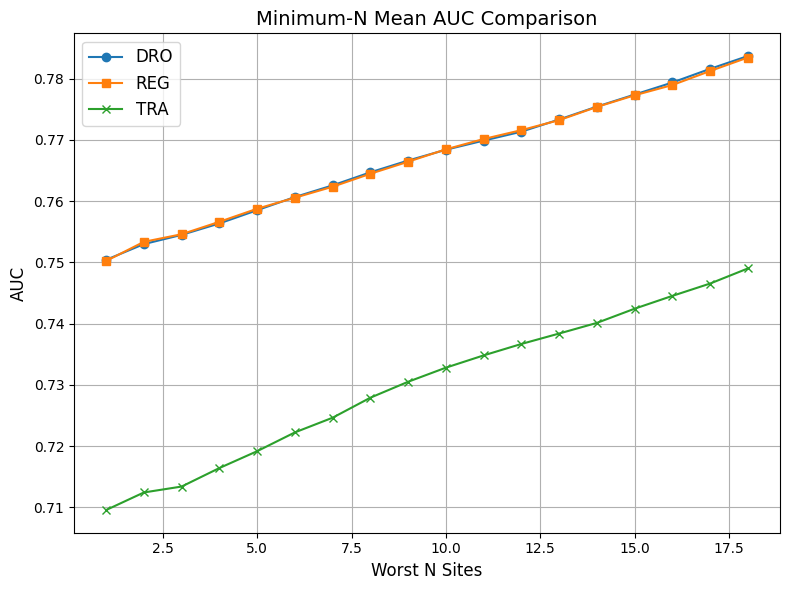

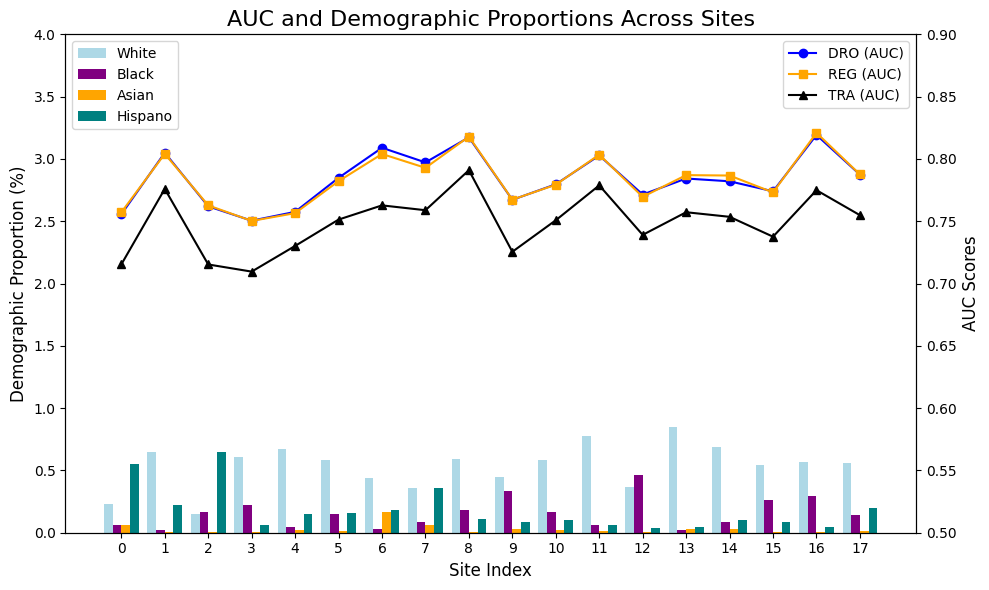

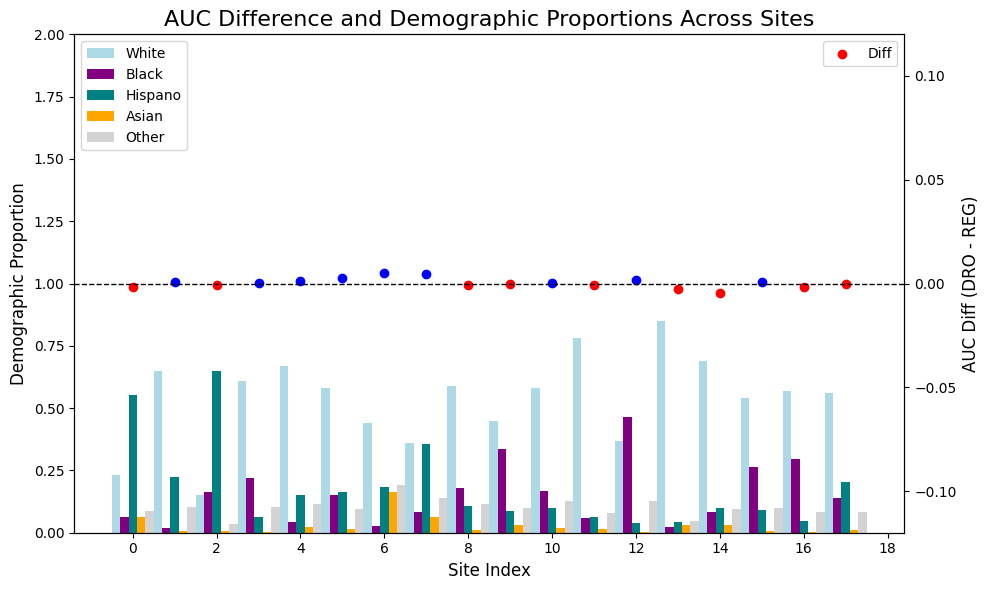


Mean's Comparison Results:
              Comparison    t_stat   p_value
0  Regularization vs DRO -0.440922  0.664826


,Comparison,t_stat,p_value
0,Regularization vs DRO,-0.440922,0.664826


In [3]:
from src.utils_plot import plot_auc_demographic_comparison
trad_auc = trad_results["auc_all"]
reg_auc = reg_results["auc_all"]
dro_auc = dro_results["auc_all"]
x_values = list(range(0, len(dro_auc) ))
bar_width = 0.2
color = ['lightblue', 'purple', 'teal', 'orange', 'lightgray']
plot_auc_demographic_comparison(
    trad_auc,
    reg_auc,
    dro_auc,
    white_proportion,
    black_proportion,
    asian_proportion,
    hispano_proportion,
    other_proportion,
    filtered_list,
)

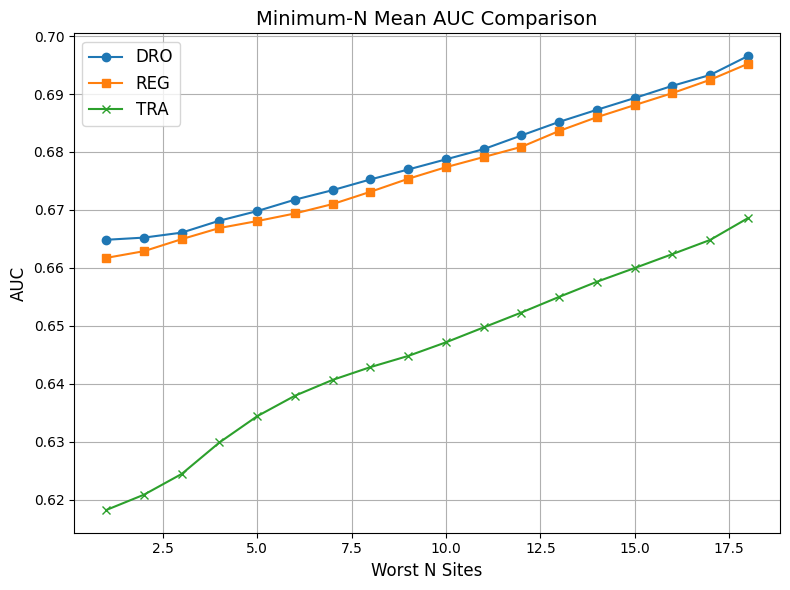

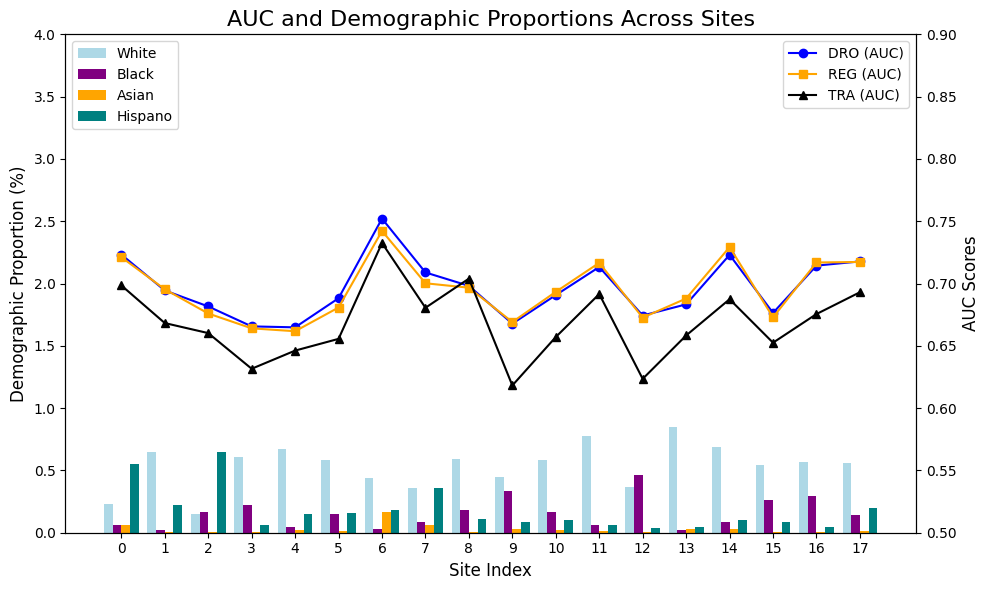

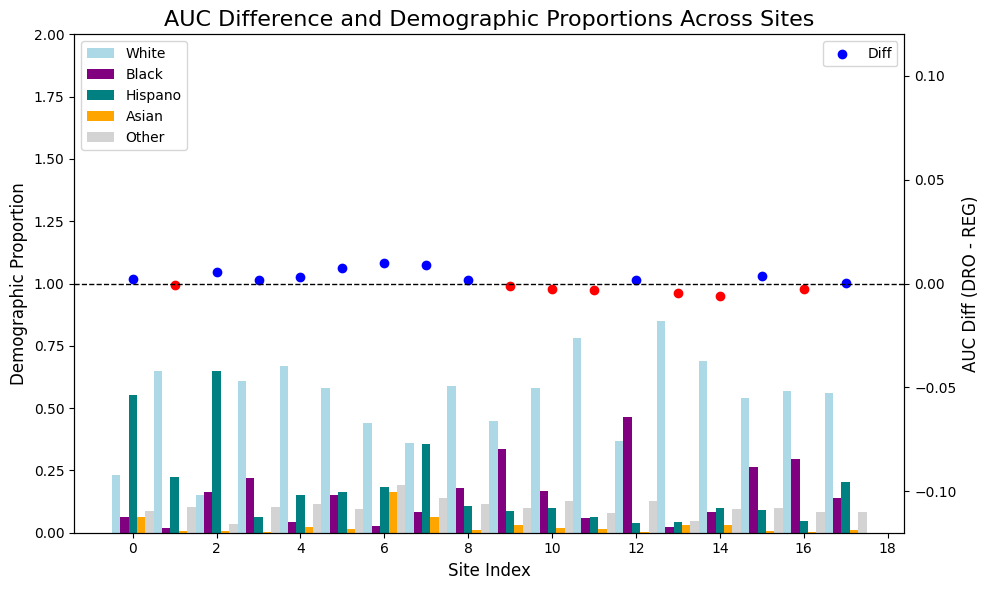


Mean's Comparison Results:
              Comparison  t_stat   p_value
0  Regularization vs DRO -1.2483  0.228841


,Comparison,t_stat,p_value
0,Regularization vs DRO,-1.2483,0.228841


In [4]:
# AUCs on sites excluding y_t == 3
trad_auc_4 = trad_results["auc_exclude_3"]
reg_auc_4 = reg_results["auc_exclude_3"]
dro_auc_4 = dro_results["auc_exclude_3"]

# AUCs on non-white group excluding y_t == 3
reg_white_4 = reg_results["auc_non_white_exclude_3"]
dro_white_4 = dro_results["auc_non_white_exclude_3"]


plot_auc_demographic_comparison(
    trad_auc_4,
    reg_auc_4,
    dro_auc_4,
    white_proportion,
    black_proportion,
    asian_proportion,
    hispano_proportion,
    other_proportion,
    filtered_list,
)

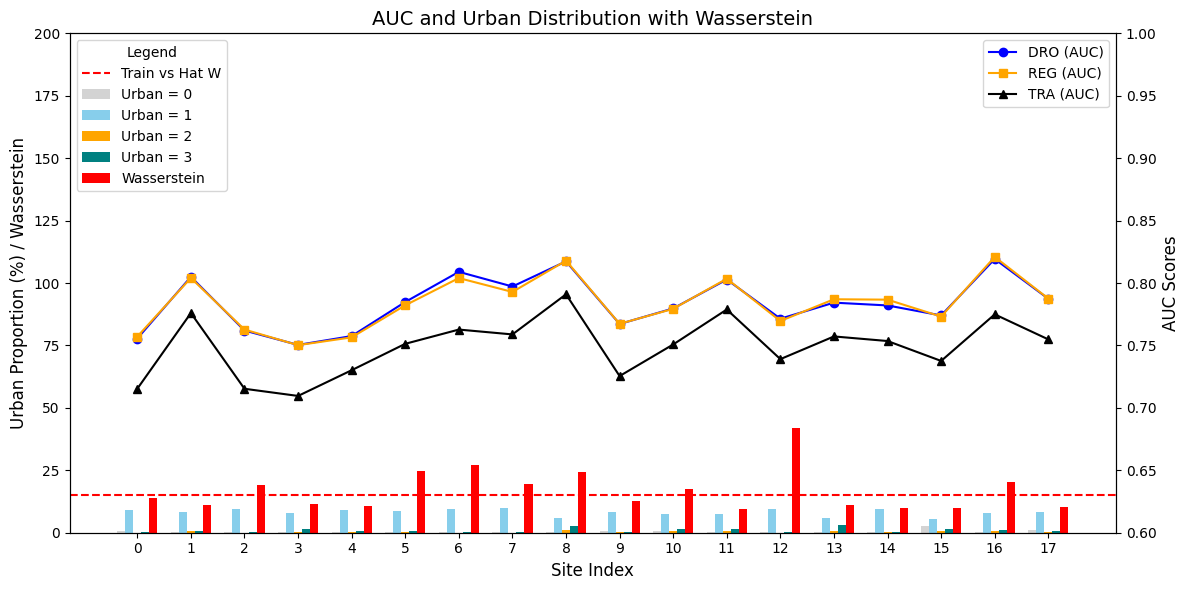

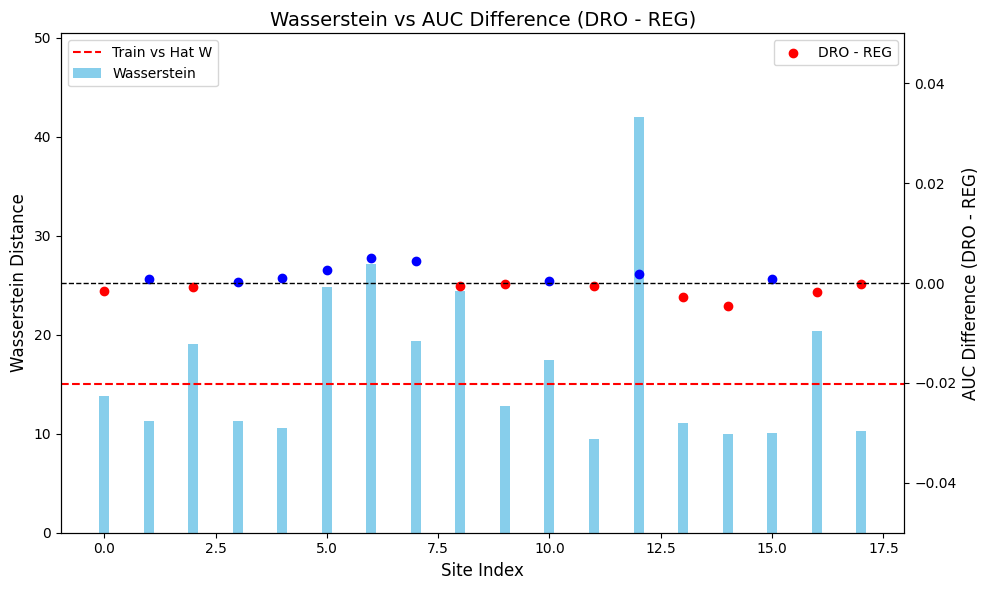


T-test Comparison Results:
                      Comparison     t_stat       p_value
0  Traditional vs Regularization -20.724721  1.671391e-13
1             Traditional vs DRO -20.051373  2.869809e-13
2          Regularization vs DRO  -0.440922  6.648256e-01


In [5]:
from src.utils_plot import plot_wasserstein_and_urban_vs_auc


was_value, auc_diff, ttest_result, was_train_hat = plot_wasserstein_and_urban_vs_auc(
    data_train=data_train,
    y_train=y_train,
    data_mapping=data_mapping,
    hatdata=hatadata_m,
    filtered_list=filtered_list,
    top_vars=top_vars,
    trad_auc=trad_auc,
    reg_auc=reg_auc,
    dro_auc=dro_auc
)

100%|██████████| 200/200 [00:12<00:00, 16.27it/s]
/Users/gaozhiyuan/DRO_prediction/src/utils_shap.py:83: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


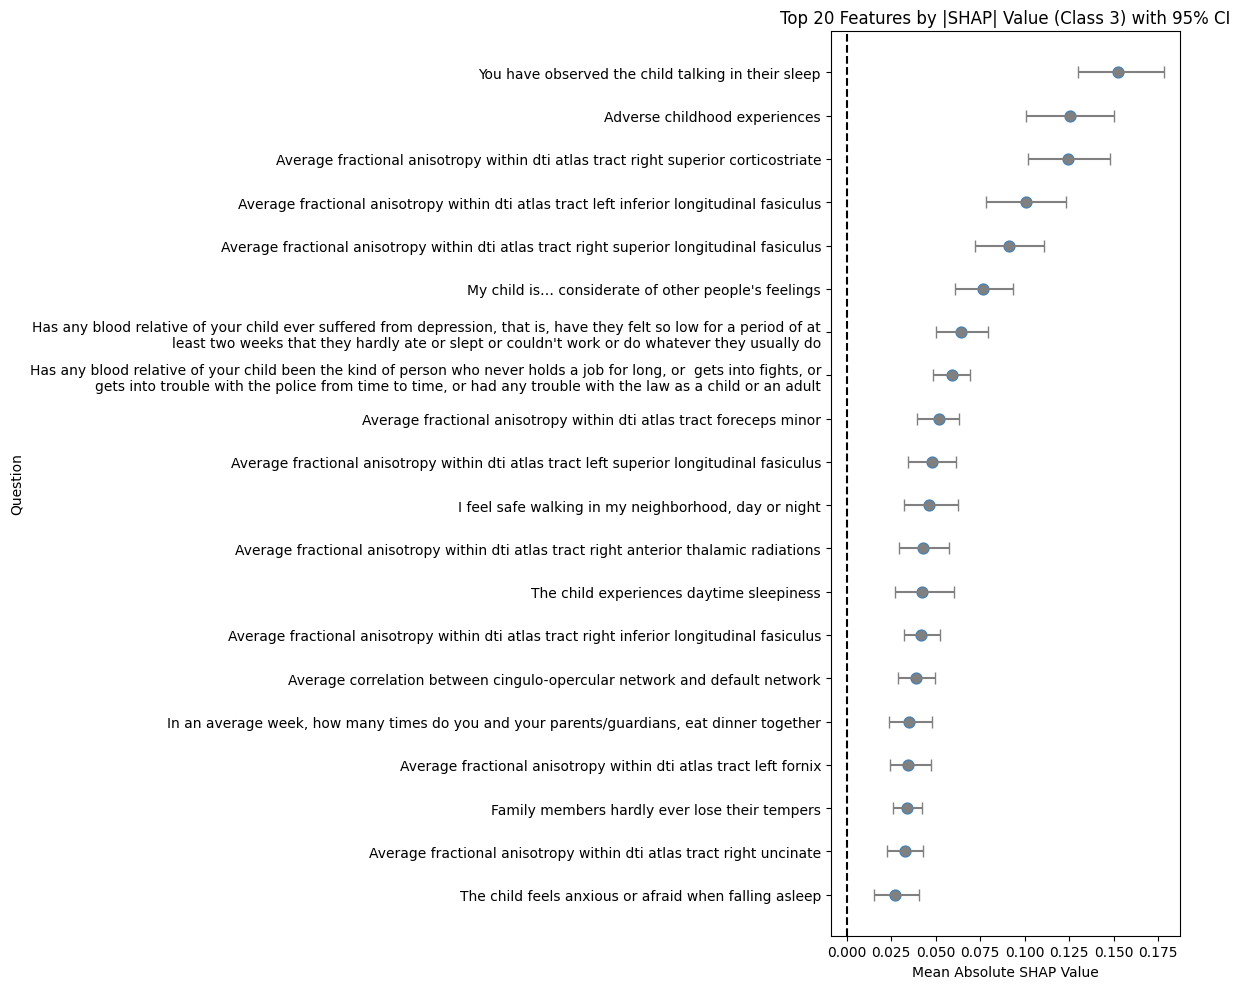

In [6]:
from src.utils_shap import compute_and_plot_shap_kernel_autoquestion

X_np = X_train  
summary = compute_and_plot_shap_kernel_autoquestion(
    trad_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)

100%|██████████| 200/200 [00:12<00:00, 16.38it/s]


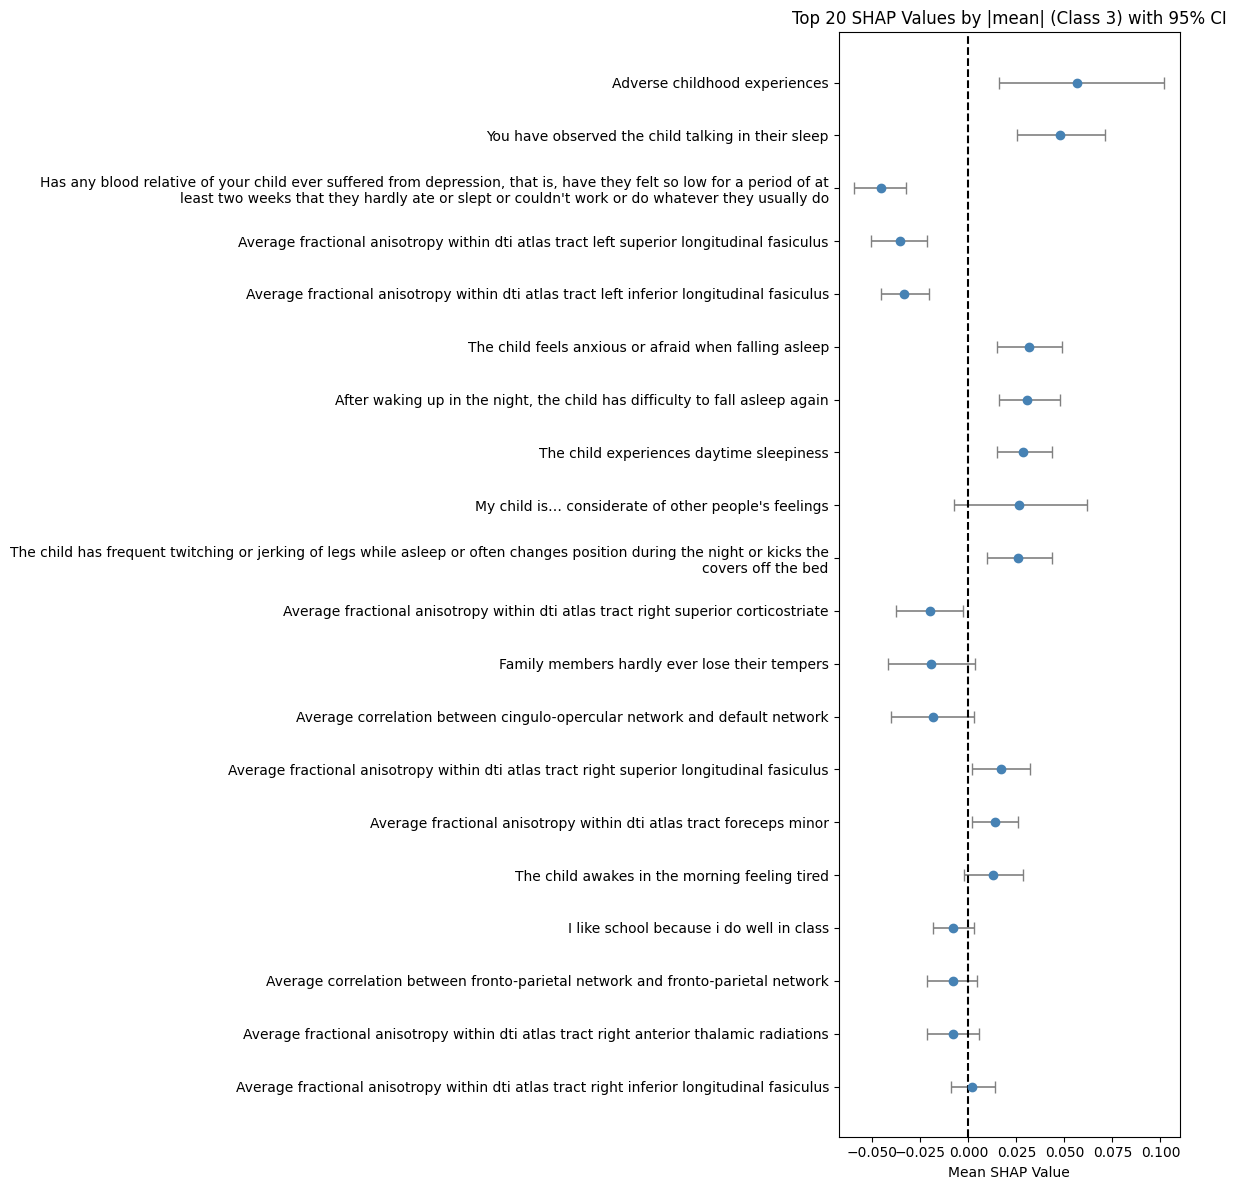

In [24]:
summary = compute_and_plot_shap_kernel_autoquestion(
    reg_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)

100%|██████████| 200/200 [00:12<00:00, 16.36it/s]


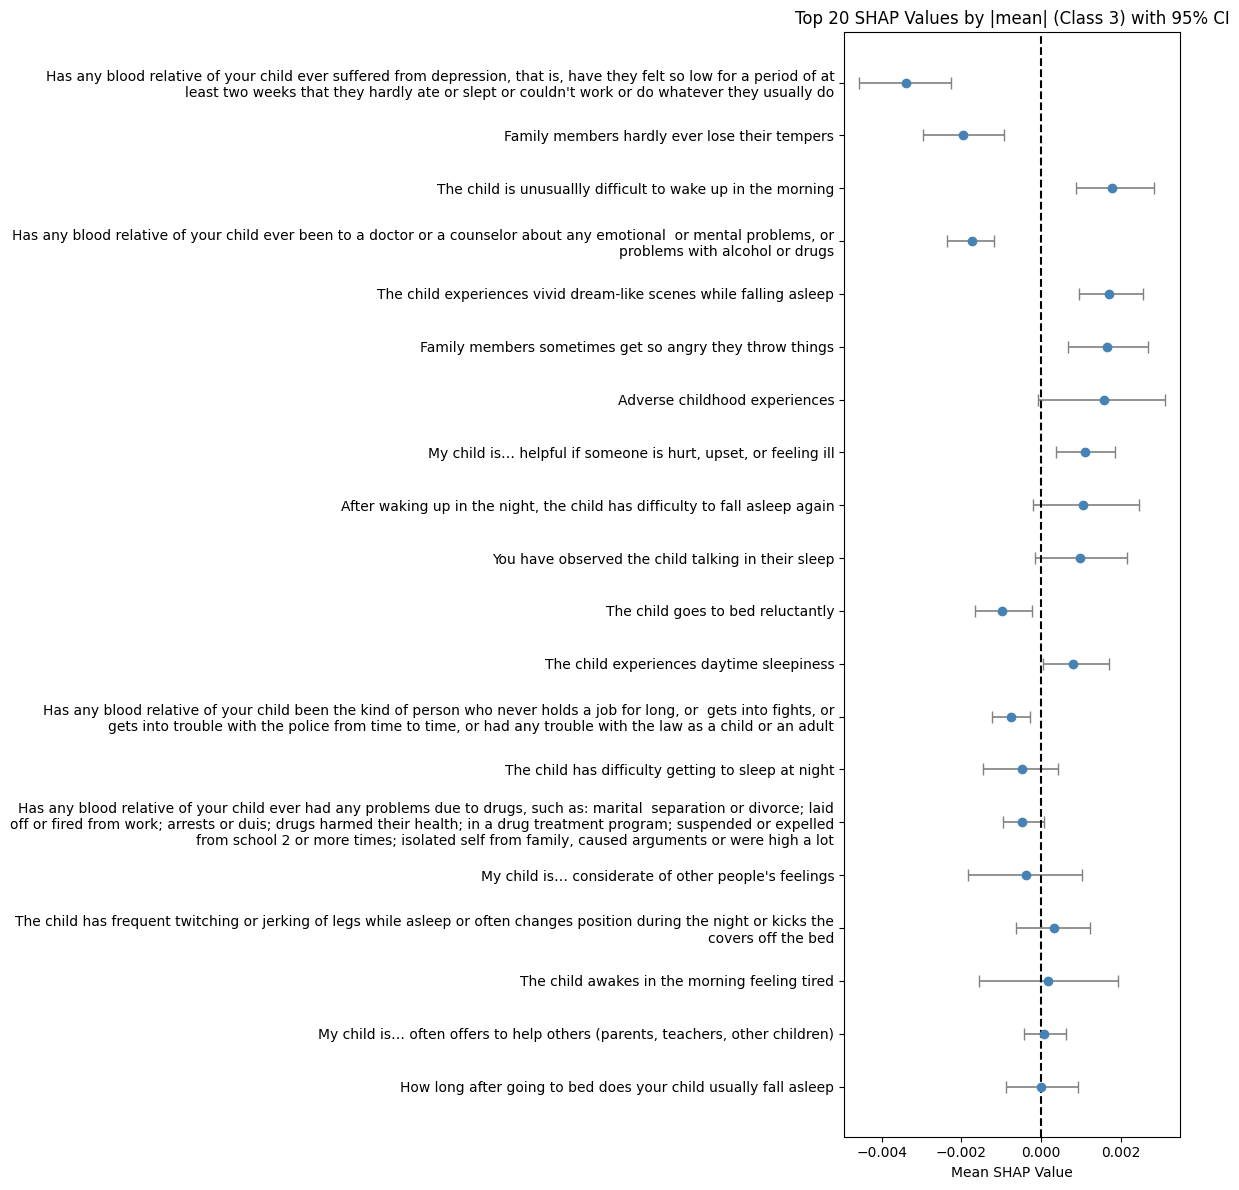

In [25]:
summary = compute_and_plot_shap_kernel_autoquestion(
    dro_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)